In [2]:
# Import packages
!pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.decomposition import PCA
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

  Using cached tslearn-0.6.2-py3-none-any.whl (369 kB)


In [3]:
from sklearn.cluster import KMeans, DBSCAN

In [4]:
# Load the dataset
data_path = os.path.join(os.getcwd(), 'Spotify_Dataset_V3.csv')
df = pd.read_csv(data_path, delimiter=';')
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df["Day_in_week"] = df["Date"].dt.dayofweek
df["Month"] = df["Date"].dt.month
df.head()

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL,Day_in_week,Month
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,Eslabon Armado,Nationality 1,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,0,5
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,Peso Pluma,Nationality 2,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,0,5
2,2,WHERE SHE GOES,Bad Bunny,2023-05-29,0.652,0.800,-4019.0,0.061,0.143,0.629,...,Bad Bunny,Nationality 1,Puerto Rico,Latin-America,199,199.0,7ro0hRteUMfnOioTFI5TG1,https://open.spotify.com/track/7ro0hRteUMfnOio...,0,5
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,...,Yng Lvcas,Nationality 1,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,0,5
4,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,...,Peso Pluma,Nationality 2,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,0,5


# Data Preparation

In [5]:
# Clean - Drop Duplicates
df_clean = df.drop_duplicates(subset=["Date", "id"], keep="last").copy()
df_clean.shape

(467061, 22)

In [6]:
# Filtering out songs that appears less than 14 days
df_appear_count = df_clean.groupby('id').size().reset_index(name='count')
ids_to_be_used = df_appear_count[df_appear_count["count"] > 30]["id"]
df_clean = df_clean[df_clean["id"].isin(ids_to_be_used)]
df_clean.shape

(424796, 22)

In [7]:
df_min_date = df_clean.groupby('id')['Date'].min().reset_index(name='Date')
ids_to_be_used = df_min_date[df_min_date['Date'] < '2022-05-29']['id']
df_clean = df_clean[df_clean["id"].isin(ids_to_be_used)]
df_clean.shape

(391509, 22)

### Day Since Appear

In [8]:
df_points = df_clean[["Points (Total)", "Date", "id"]].copy()
# df_points = df_points[:100000].copy()

# Calculate Day Since Appear
# df_points.sort_values(by=['id', 'Date'], inplace=True)
df_points['day_since_appear'] = df_points.groupby('id')['Date'].transform(lambda x: (x - x.min()).dt.days + 1)

In [9]:
# df_points['Points (Total)'] = pd.cut(df_points["Points (Total)"], bins=10, labels=range(1, 11)).astype(int)

### Fill in 0 for missing "Points (Total)"

In [10]:
day_since_appear = pd.Series(range(1,df_points['day_since_appear'].max()))
uuids = df_points["id"].unique()

all_combinations = pd.MultiIndex.from_product([uuids, day_since_appear], names=['id', 'day_since_appear'])
full_df = pd.DataFrame(index=all_combinations).reset_index()

merged_df = pd.merge(full_df, df_points, on=['id', 'day_since_appear'], how='left')
merged_df['Points (Total)'].fillna(0, inplace=True)
merged_df.head()

,id,day_since_appear,Points (Total),Date
0,4Dvkj6JhhA12EX05fT7y2e,1,200.0,2022-05-20
1,4Dvkj6JhhA12EX05fT7y2e,2,200.0,2022-05-21
2,4Dvkj6JhhA12EX05fT7y2e,3,200.0,2022-05-22
3,4Dvkj6JhhA12EX05fT7y2e,4,200.0,2022-05-23
4,4Dvkj6JhhA12EX05fT7y2e,5,200.0,2022-05-24


<Axes: xlabel='day_since_appear', ylabel='Points (Total)'>

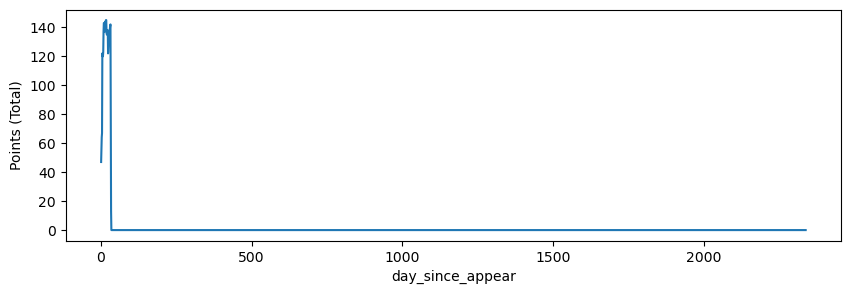

In [11]:
# Random song & Plot Popularity over time
plt.figure(figsize=(10,3))
sample = merged_df.sample(n=1).iloc[0]
sns.lineplot(merged_df[merged_df["id"] == sample["id"]], x="day_since_appear", y="Points (Total)")

In [12]:
# Pivot the DataFrame for clustering
pivot_df = merged_df.pivot(index='id', columns='day_since_appear', values='Points (Total)')
df_smoothed = pivot_df.apply(lambda row: row.rolling(window=7, step=7, min_periods=1).mean(), axis=1)
df_smoothed

day_since_appear,1,8,15,22,29,36,43,50,57,64,...,2276,2283,2290,2297,2304,2311,2318,2325,2332,2339
id,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,151.0,150.428571,151.571429,147.000000,136.142857,144.285714,144.285714,139.000000,132.285714,127.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003vvx7Niy0yvhvHt4a68B,6.0,1.857143,1.000000,2.000000,0.142857,0.285714,0.000000,0.000000,1.142857,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00Blm7zeNqgYLPtW6zg8cj,193.0,190.000000,185.000000,180.285714,172.285714,152.857143,151.714286,127.428571,143.142857,165.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00EPIEnX1JFjff8sC6bccd,11.0,49.285714,90.285714,90.142857,106.857143,114.571429,131.285714,131.428571,131.000000,126.428571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00ko9WaS4jOX1kEk3gvHjf,96.0,122.428571,43.857143,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7yotKA30dwTKNEGomV9ZsI,199.0,188.428571,169.714286,159.142857,153.285714,134.000000,114.142857,96.714286,65.428571,19.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7yq4Qj7cqayVTp3FF9CWbm,1.0,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7ytR5pFWmSjzHJIeQkgog4,192.0,187.428571,185.571429,193.000000,196.285714,198.857143,198.857143,199.857143,199.857143,199.714286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
pivot_df_norm = df_smoothed.T
pivot_df_norm = (pivot_df_norm-pivot_df_norm.min())/(pivot_df_norm.max()-pivot_df_norm.min())
# pivot_df_norm = (pivot_df_norm-pivot_df_norm.mean())/pivot_df_norm.std()
pivot_df_norm = pivot_df_norm.T
pivot_df_norm

day_since_appear,1,8,15,22,29,36,43,50,57,64,...,2276,2283,2290,2297,2304,2311,2318,2325,2332,2339
id,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,0.996230,0.992460,1.000000,0.969840,0.898209,0.951932,0.951932,0.917059,0.872762,0.839774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003vvx7Niy0yvhvHt4a68B,0.086598,0.026804,0.014433,0.028866,0.002062,0.004124,0.000000,0.000000,0.016495,0.014433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00Blm7zeNqgYLPtW6zg8cj,1.000000,0.984456,0.958549,0.934123,0.892672,0.792006,0.786084,0.660252,0.741673,0.856403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00EPIEnX1JFjff8sC6bccd,0.083696,0.375000,0.686957,0.685870,0.813043,0.871739,0.998913,1.000000,0.996739,0.961957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00ko9WaS4jOX1kEk3gvHjf,0.784131,1.000000,0.358226,0.001167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7yotKA30dwTKNEGomV9ZsI,1.000000,0.946877,0.852836,0.799713,0.770280,0.673367,0.573582,0.486001,0.328787,0.095477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7yq4Qj7cqayVTp3FF9CWbm,0.009831,0.004213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7ytR5pFWmSjzHJIeQkgog4,0.960000,0.937143,0.927857,0.965000,0.981429,0.994286,0.994286,0.999286,0.999286,0.998571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# selected_columns = pivot_df_norm.columns[:57]
# pivot_df_norm = pivot_df_norm[selected_columns]

In [15]:
# pivot_df.to_csv("date_point_pop_only.csv")

In [16]:
# Calculate Differentitate
df_diff = pivot_df_norm.diff(axis=1)
df_diff.drop(columns=1, inplace=True)
df_diff.head()

day_since_appear,8,15,22,29,36,43,50,57,64,71,...,2276,2283,2290,2297,2304,2311,2318,2325,2332,2339
id,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,-0.003770,0.007540,-0.030160,-0.071631,0.053723,0.000000,-0.034873,-0.044298,-0.032988,-0.383600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003vvx7Niy0yvhvHt4a68B,-0.059794,-0.012371,0.014433,-0.026804,0.002062,-0.004124,0.000000,0.016495,-0.002062,-0.014433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00Blm7zeNqgYLPtW6zg8cj,-0.015544,-0.025907,-0.024426,-0.041451,-0.100666,-0.005922,-0.125833,0.081421,0.114730,-0.031828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00EPIEnX1JFjff8sC6bccd,0.291304,0.311957,-0.001087,0.127174,0.058696,0.127174,0.001087,-0.003261,-0.034783,-0.044565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00ko9WaS4jOX1kEk3gvHjf,0.215869,-0.641774,-0.357060,-0.001167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='day_since_appear', ylabel='6DCZcSspjsKoFjzjrWoCdn'>

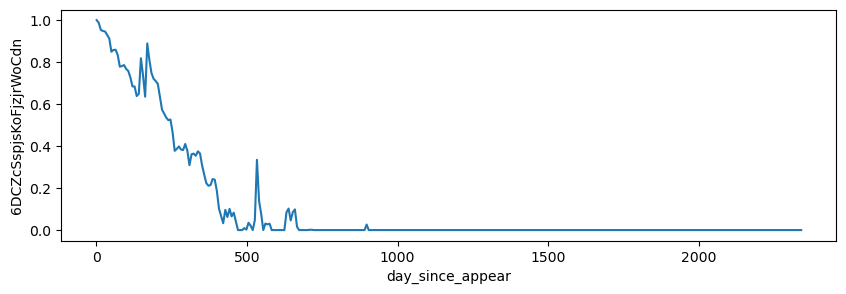

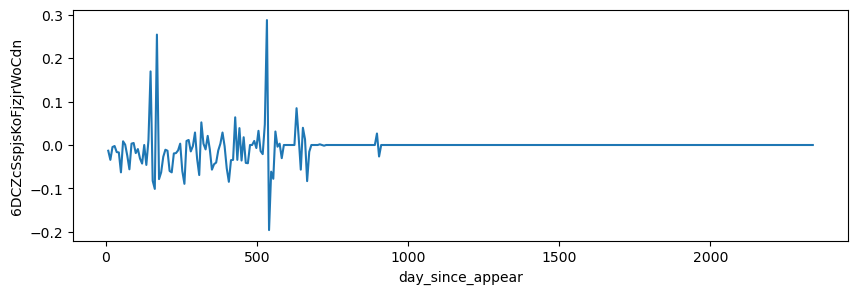

In [17]:
sample = pivot_df_norm.sample(n=1)
sample_id = sample.index[0]

plt.figure(figsize=(10,3))
sns.lineplot(sample.iloc[0])

# plt.show()
plt.figure(figsize=(10,3))
sns.lineplot(df_diff.loc[sample_id])

# Song Popularity Over time

In [17]:
# all time hit, 6RUKPb4LETWmmr3iAEQktW, 5uCax9HTNlzGybIStD3vDh
# old release, but popular in 2022, 4xkOaSrkexMciUUogZKVTS, 4UKCKdYiLN6IMA5ZESUTL7, 1kKYjjfNYxE0YYgLa7vgVY
# popu. on and off, 2jyjhRf6DVbMPU5zxagN2h, 60a0Rd6pjrkxjPbaKzXjfq
# popu. on festival, 2TE4xW3ImvpltVU0cPcKUn, 15coTBAzEN1bOeipoNDZAR

id: 0bYg9bo50gSsH3LtXe2SQn | Total count: 349
Song: All I Want for Christmas Is You | Artists: Mariah Carey | Continent: Anglo-America


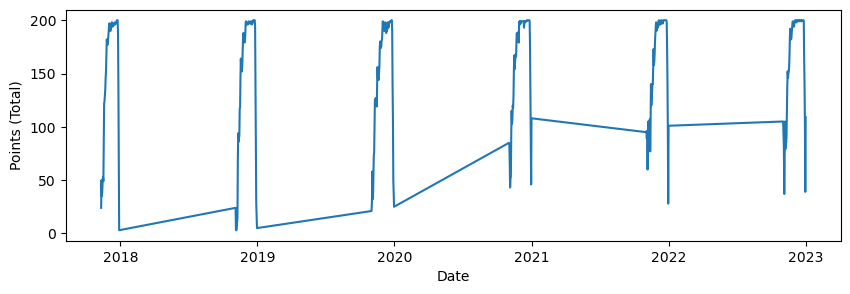

<Axes: xlabel='day_since_appear', ylabel='0bYg9bo50gSsH3LtXe2SQn'>

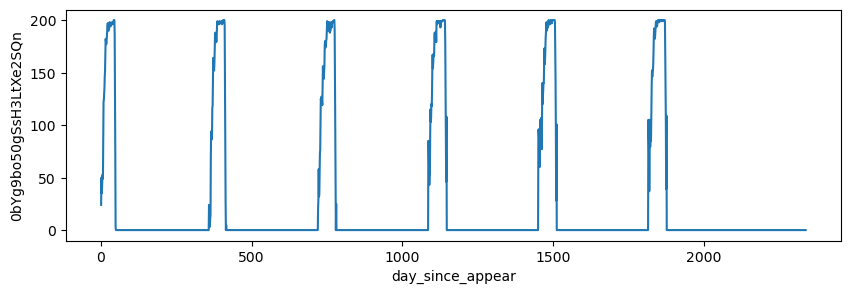

In [85]:
# sample = df_clean.sample(n=1).iloc[0]
sample = df_clean[df_clean["id"] == "0bYg9bo50gSsH3LtXe2SQn"].iloc[0]
df_focus = df_clean[df_clean["id"] == sample["id"]]

print(f'id: {sample["id"]} | Total count: {df_focus.shape[0]}')
print(f'Song: {sample["Title"]} | Artists: {sample["Artists"]} | Continent: {sample["Continent"]}')

# Histogram
# plt.figure(figsize=(10, 3))
# sns.histplot(df_focus["Date"], bins=50)

# Popularity over time
plt.show()
plt.figure(figsize=(10, 3))
sns.lineplot(data=df_focus, x="Date", y="Points (Total)")

plt.show()
plt.figure(figsize=(10,3))
sns.lineplot(pivot_df.loc[sample["id"]])


# Clustering

<Axes: xlabel='cluster', ylabel='Count'>

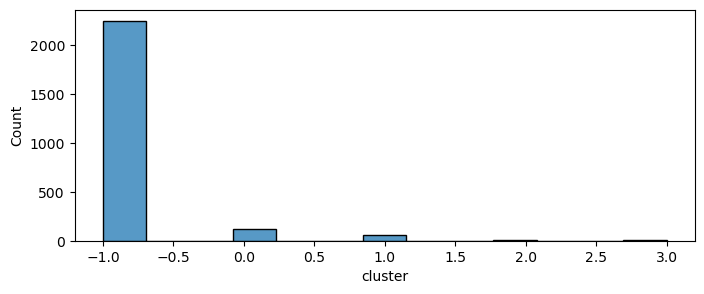

In [19]:
# # df_cluster_original = df_clean.drop(columns=["Day_in_week", "Month"]).copy()
# df_cluster_original = pivot_df.copy()

# dbscan = DBSCAN(eps=100)
# dbscan.fit(df_cluster_original)

# df_cluster = df_cluster_original.copy()
# df_cluster['cluster'] = dbscan.labels_
# labels = dbscan.labels_

# # pca = PCA(n_components=4)  # Reduce to 2 dimensions
# # X_2d = pca.fit_transform(df_cluster_original)

# # plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')

# plt.figure(figsize=(8, 3))
# sns.histplot(df_cluster["cluster"])

0.29341678663572585


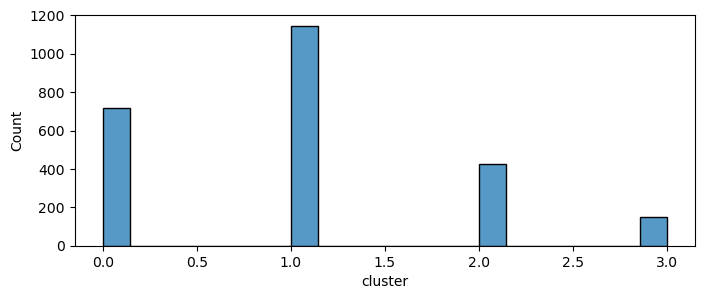

In [18]:
# # df_cluster_original = df_clean.drop(columns=["Day_in_week", "Month"]).copy()
# df_cluster_original = pivot_df_norm.copy()

# kmeans = KMeans(n_clusters=4, n_init="auto", max_iter=300)
# kmeans.fit(df_cluster_original)

# df_cluster = df_cluster_original.copy()
# df_cluster['cluster'] = kmeans.labels_
# labels = kmeans.labels_

# # pca = PCA(n_components=4)  # Reduce to 2 dimensions
# # X_2d = pca.fit_transform(df_cluster_original)

# # plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')

# plt.figure(figsize=(8, 3))
# sns.histplot(df_cluster["cluster"])

# from sklearn.metrics import silhouette_score
# sil_coeff = silhouette_score(df_cluster.drop(columns = 'cluster'),df_cluster['cluster'])
# print(sil_coeff)

Attempt using TimeSeriesKMeans

79.818 --> 56.292 --> 54.028 --> 53.435 --> 53.216 --> 53.105 --> 53.042 --> 52.976 --> 52.916 --> 52.871 --> 52.842 --> 52.825 --> 52.815 --> 52.804 --> 52.793 --> 52.783 --> 52.777 --> 52.774 --> 52.773 --> 52.772 --> 52.771 --> 52.770 --> 52.770 --> 52.770 --> 
0.18216100273510893


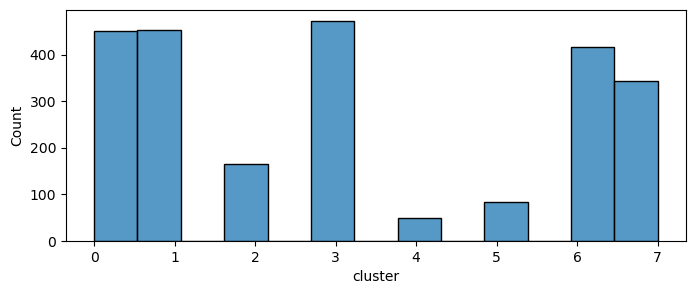

In [114]:
# df_cluster_original = pivot_df_norm.copy()
# df_ts_scaled = TimeSeriesScalerMeanVariance().fit_transform(df_cluster_original.values)

# kmeans = TimeSeriesKMeans(n_clusters=8, verbose=True)
# labels = kmeans.fit_predict(df_ts_scaled)

# df_cluster = df_cluster_original.copy()
# df_cluster['cluster'] = labels

# plt.figure(figsize=(8, 3))
# sns.histplot(df_cluster["cluster"])

# from sklearn.metrics import silhouette_score
# sil_coeff = silhouette_score(df_cluster.drop(columns = 'cluster'),df_cluster['cluster'])
# print(sil_coeff)

Attempt using summary statistics

0.36920505412021687


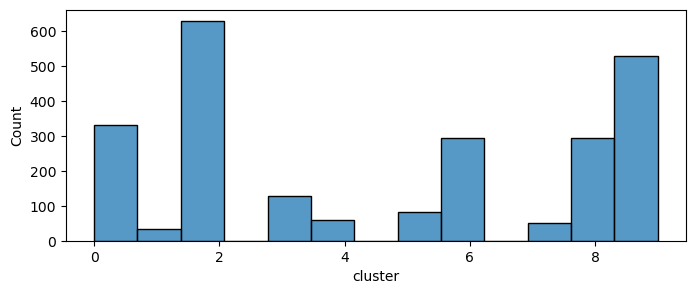

In [228]:
# df_cluster_original = df_clean.drop(columns=["Day_in_week", "Month"]).copy()
df_cluster_original = pivot_df.copy()

kmeans = KMeans(n_clusters=10, n_init="auto", max_iter=300)
kmeans.fit(summary_df)

df_cluster = df_cluster_original.copy()
df_cluster['cluster'] = kmeans.labels_
labels = kmeans.labels_

# pca = PCA(n_components=4)  # Reduce to 2 dimensions
# X_2d = pca.fit_transform(df_cluster_original)

# plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')

plt.figure(figsize=(8, 3))
sns.histplot(df_cluster["cluster"])

from sklearn.metrics import silhouette_score
sil_coeff = silhouette_score(summary_df,df_cluster['cluster'])
print(sil_coeff)

In [106]:
# Ideas for future improvements to our clustering:
# - Much of our clustering seems to be done depending on how many of the weeks have 0 points. These weeks make up a large proportion of the data so are weighted heavily. Therefore for many songs with shorter successes the actual shape of the popularity graph is ignored.
# - To combat this we considered normalising the 'day since appear' axis to only range from the first point-scoring week to the last point-scoring week. However this loses information on the duration of popularity and we saw that when the x-axis is stretched/compressed in this way the popularity graphs of 'Alltime hits' and 'Viral hits' were very similar, so we lose this distinction
# - A better option is to summarise the popularity profile into some metrics that are representative of the shape of the chart. For example: duration of popularity, number of peaks, popularity in week X, differential (trend) of popularity in week Y, time between peaks (to identify 'Periodic' hits that will peak every 365 days)


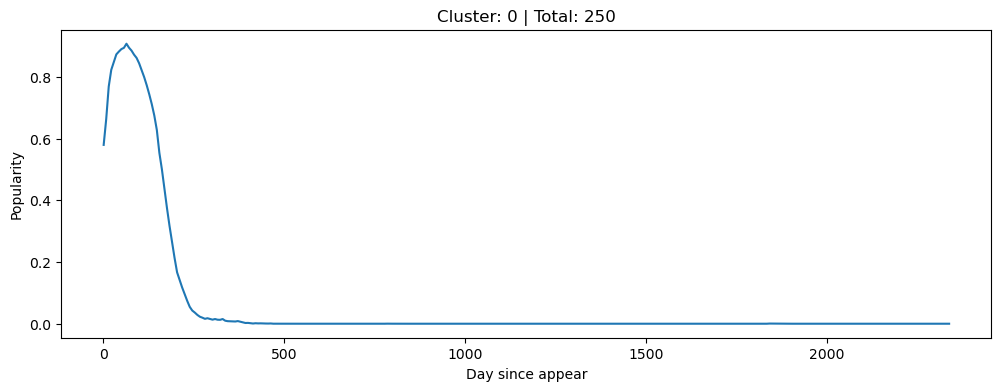

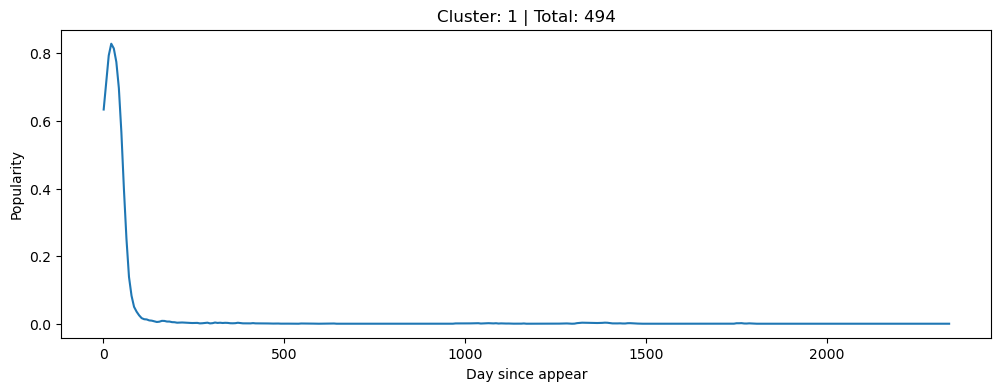

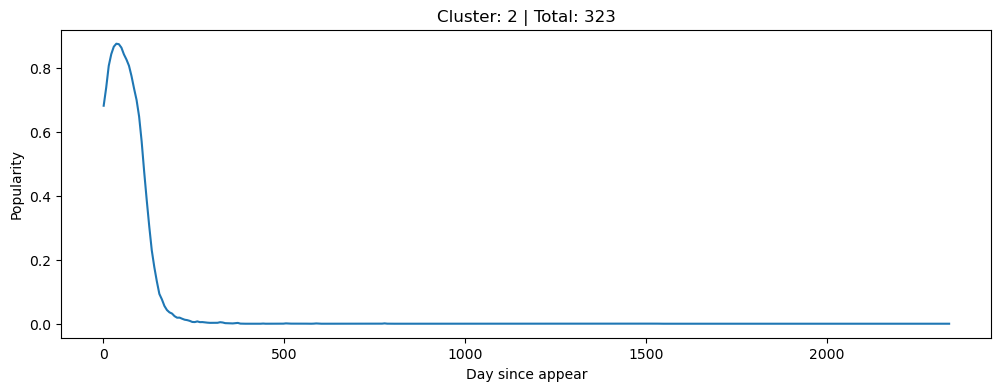

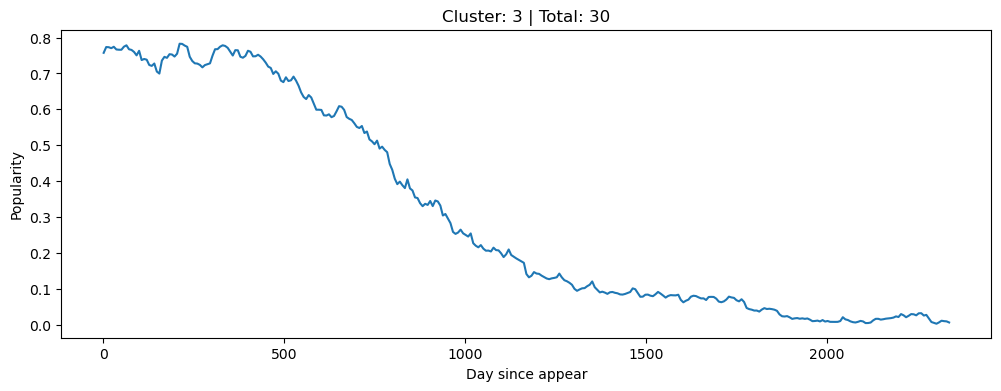

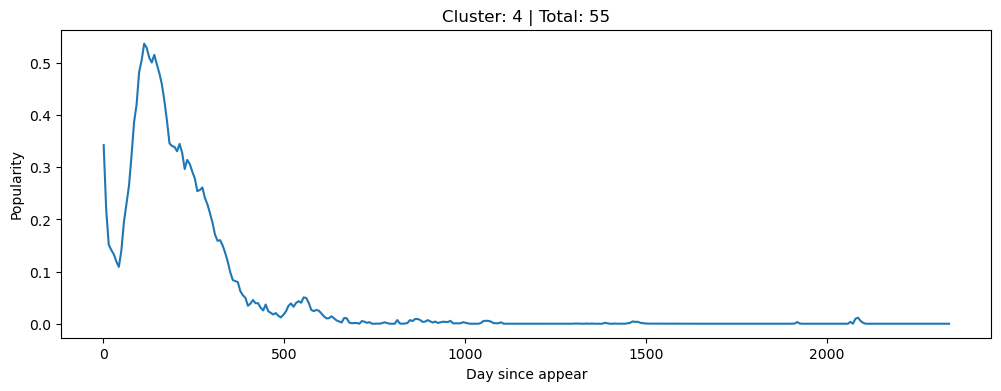

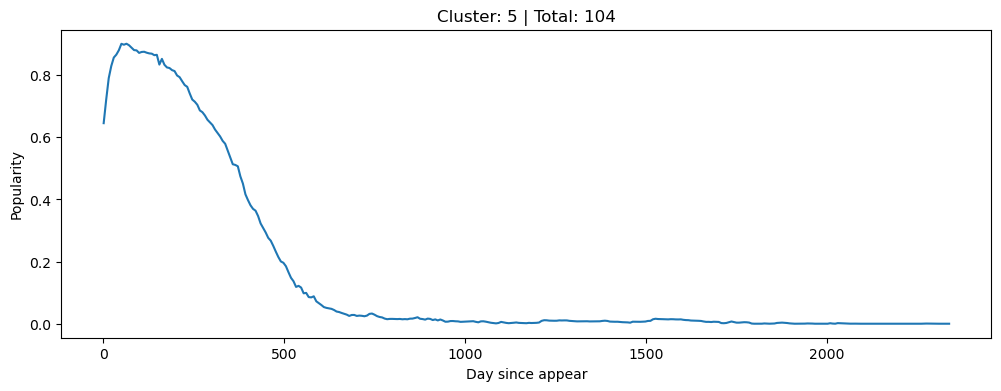

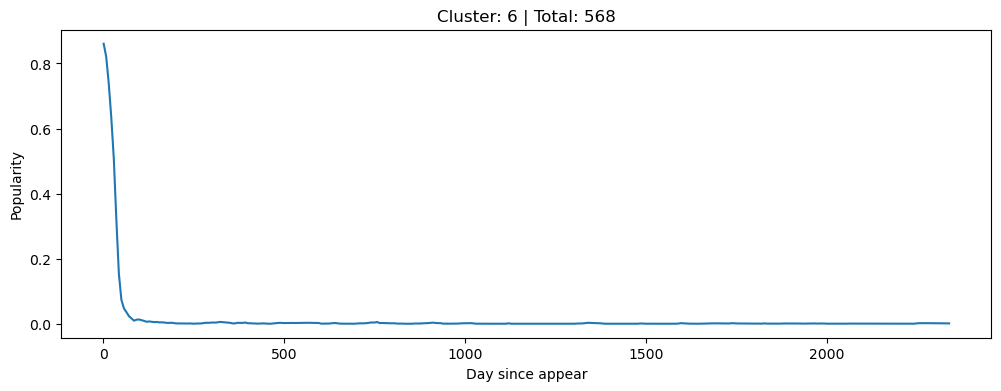

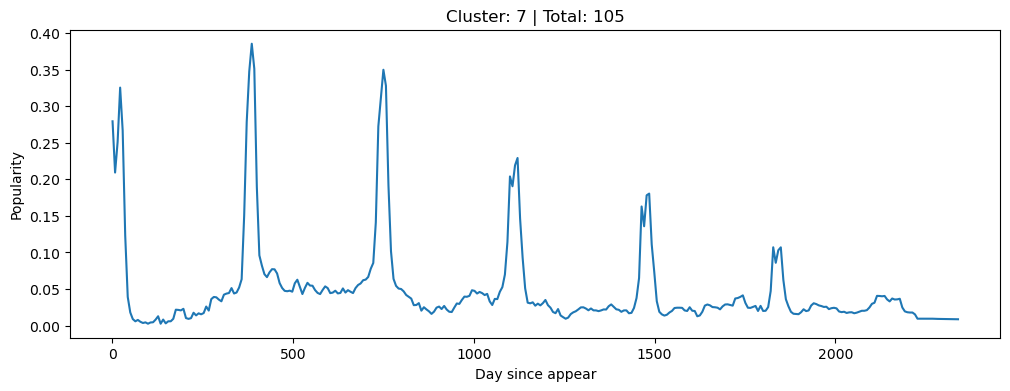

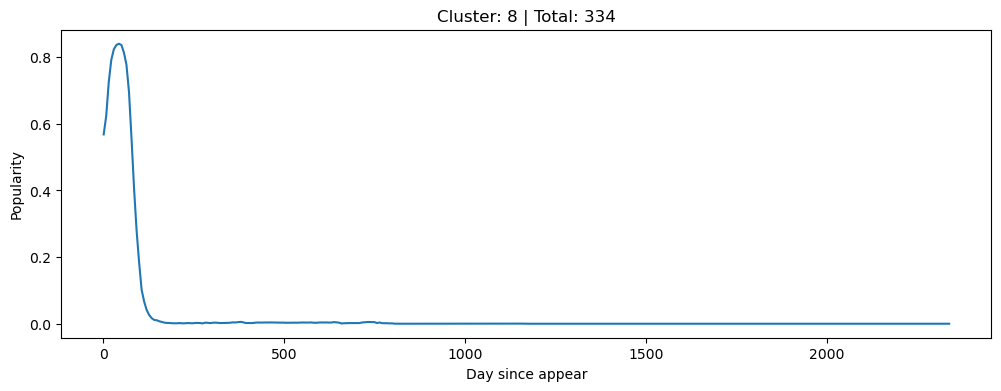

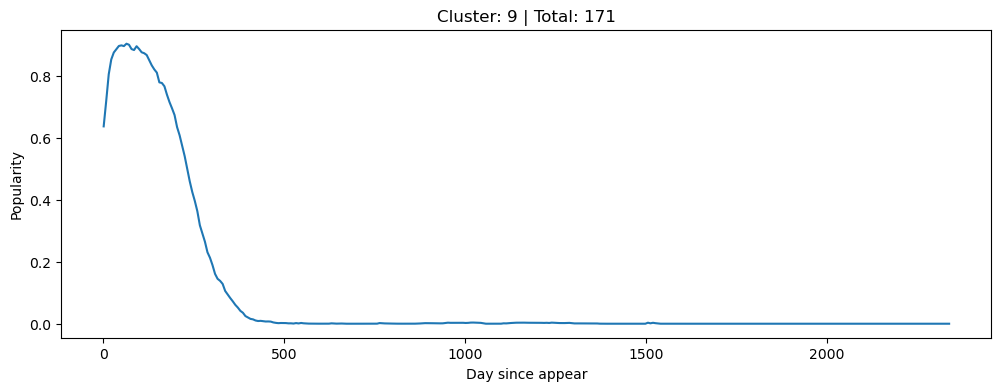

In [232]:
for cluster in sorted(df_cluster["cluster"].unique()):
    cluster_size = df_cluster[df_cluster["cluster"] == cluster].shape[0]
    sample = df_cluster[df_cluster["cluster"] == cluster]
    df_sample = sample.drop(columns="cluster").mean()

    plt.figure(figsize=(12, 4))
    ax = sns.lineplot(df_sample.T)
    ax.set_title(f'Cluster: {cluster} | Total: {cluster_size}')
    ax.set(xlabel='Day since appear', ylabel='Popularity')
    plt.show()

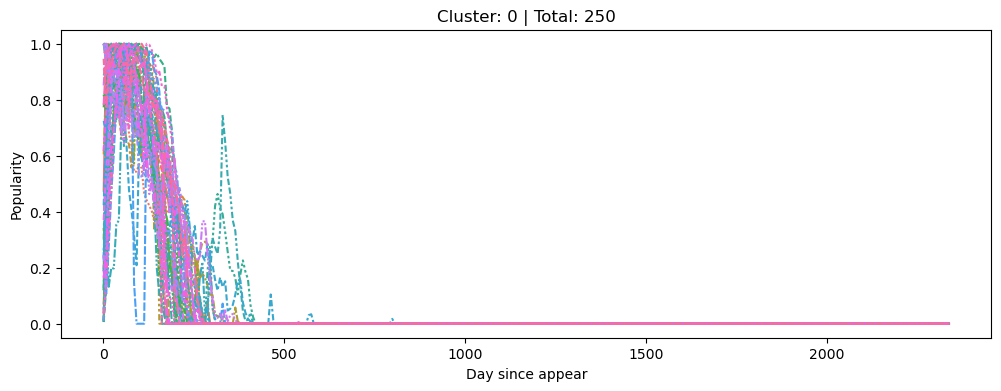

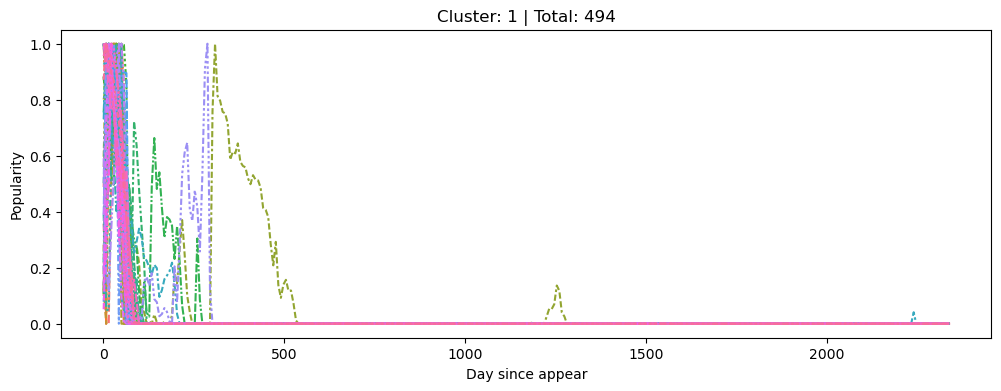

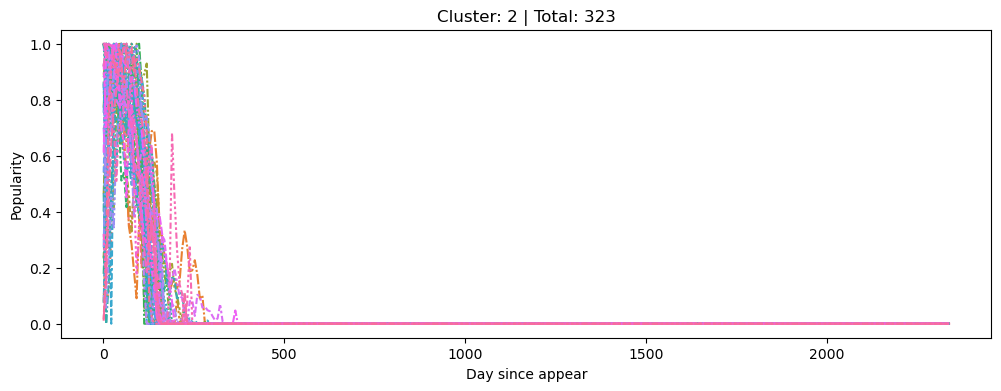

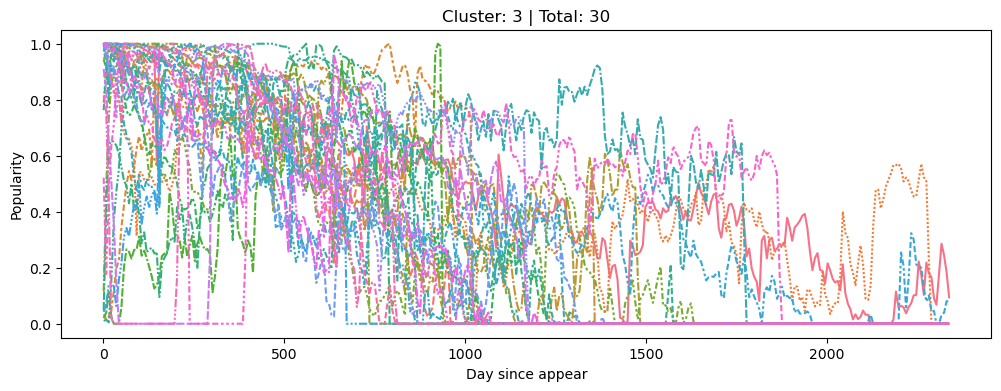

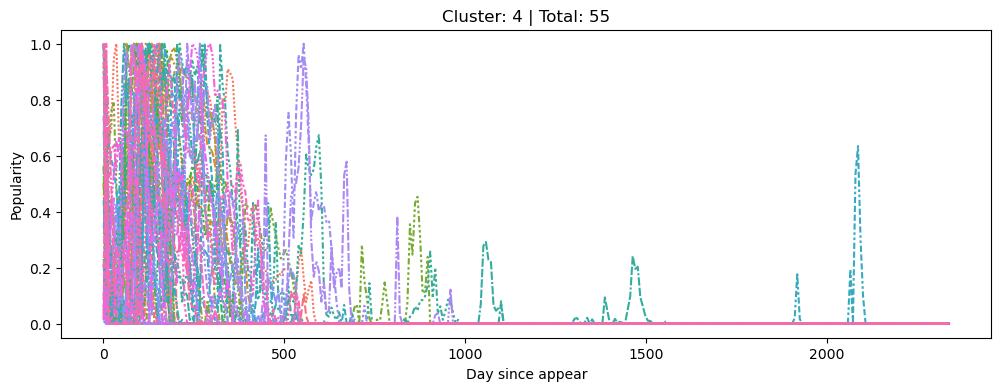

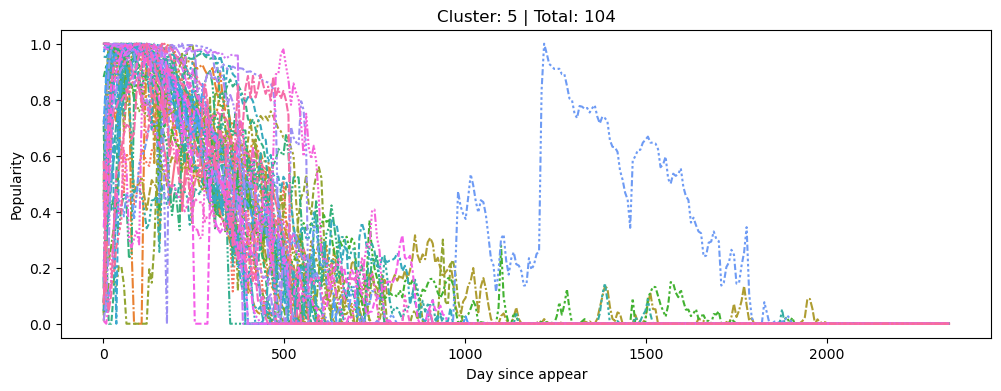

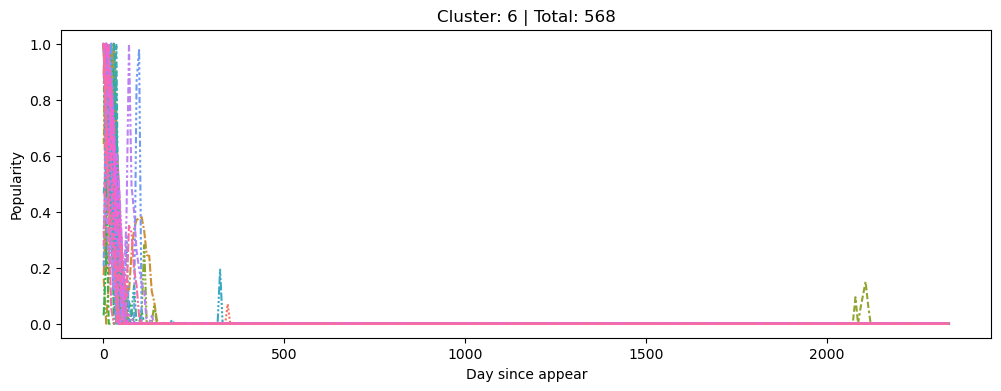

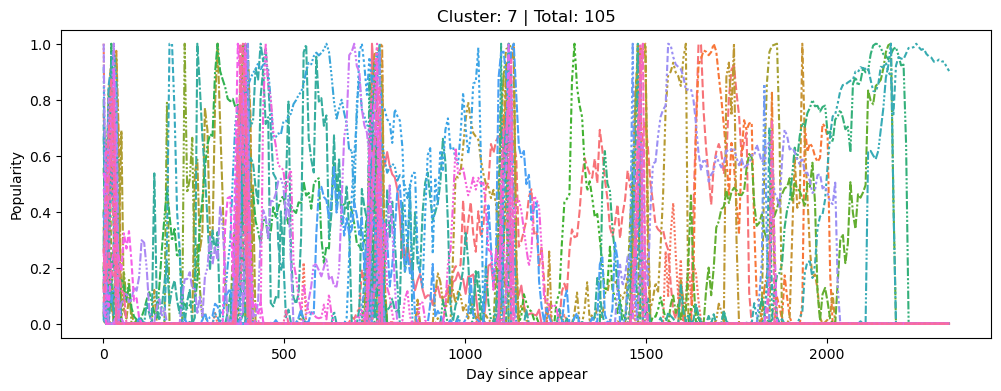

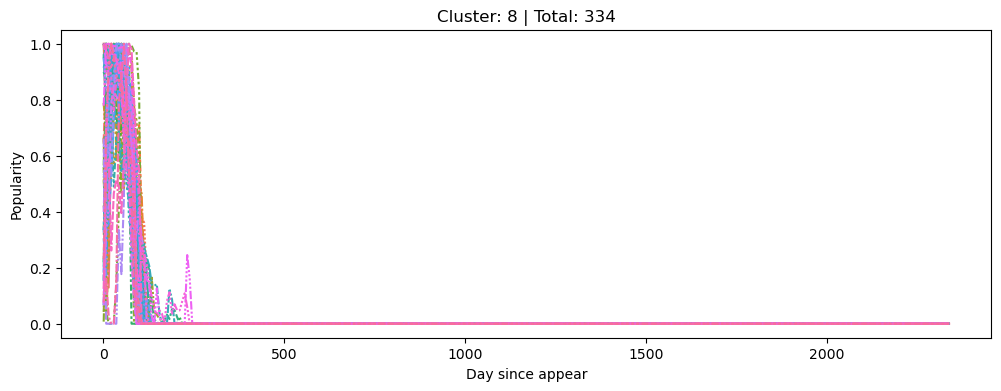

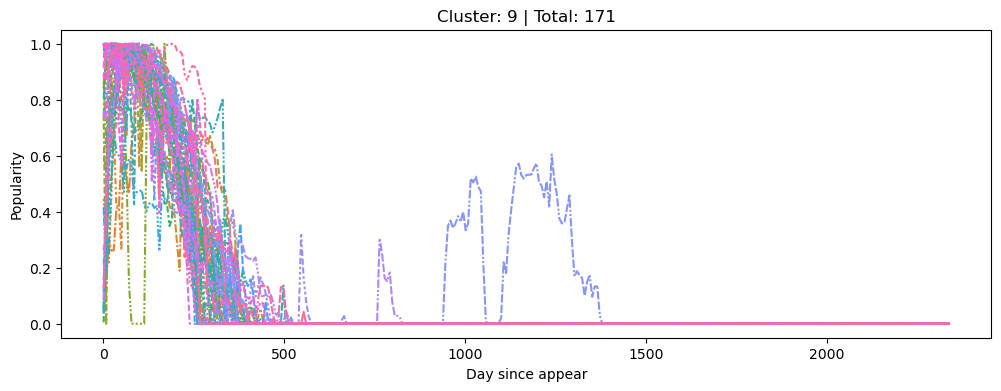

In [233]:
for cluster in sorted(df_cluster["cluster"].unique()):
    cluster_size = df_cluster[df_cluster["cluster"] == cluster].shape[0]
    sample = df_cluster[df_cluster["cluster"] == cluster].sample(min(cluster_size, 50))
    df_sample = sample.drop(columns="cluster")

    plt.figure(figsize=(12, 4))
    ax = sns.lineplot(df_sample.T)
    ax.set_title(f'Cluster: {cluster} | Total: {cluster_size}')
    ax.set(xlabel='Day since appear', ylabel='Popularity')
    ax.get_legend().remove()
    plt.show()

In [117]:
# inspect each cluster
ids_to_be_used = df_cluster[df_cluster["cluster"] == 5].index
df_clean[df_clean["id"].isin(ids_to_be_used)].groupby("id").first()

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,# of Artist,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),Song URL,Day_in_week,Month
id,,,,,,,,,,,,,,,,,,,,,
0247StOpd3AkeBQzANX4Zf,53,Do They Know It's Christmas? - 1984 Version,Band Aid,2021-12-26,0.599,0.642,-6936.0,0.036,0.164,0.0,...,Artist 1,Band Aid,Nationality 1,United Kingdom,Europe,148,148.0,https://open.spotify.com/track/0247StOpd3AkeBQ...,6,12
09mEdoA6zrmBPgTEN5qXmN,197,Call Out My Name,The Weeknd,2023-05-18,0.461,0.593,-4954.0,0.036,0.170,0.0,...,Artist 1,The Weeknd,Nationality 1,Canada,Anglo-America,4,4.0,https://open.spotify.com/track/09mEdoA6zrmBPgT...,3,5
0YWUHZPJVg4iujddsJDwhM,117,My Only Wish (This Year),Britney Spears,2022-12-26,0.669,0.843,-3766.0,0.027,0.169,0.0,...,Artist 1,Britney Spears,Nationality 1,United States,Anglo-America,84,84.0,https://open.spotify.com/track/0YWUHZPJVg4iujd...,0,12
0bYg9bo50gSsH3LtXe2SQn,92,All I Want for Christmas Is You,Mariah Carey,2022-12-31,0.336,0.627,-7463.0,0.038,0.164,0.0,...,Artist 1,Mariah Carey,Nationality 1,United States,Anglo-America,109,109.0,https://open.spotify.com/track/0bYg9bo50gSsH3L...,5,12
0ct6r3EGTcMLPtrXHDvVjc,200,The Nights,Avicii,2022-07-11,0.527,0.835,-5298.0,0.043,0.017,0.0,...,Artist 1,Avicii,Nationality 1,Sweden,Europe,1,1.0,https://open.spotify.com/track/0ct6r3EGTcMLPtr...,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7lQ8MOhq6IN2w8EYcFNSUk,120,Without Me,Eminem,2023-05-29,0.908,0.669,-2827.0,0.074,0.003,0.0,...,Artist 1,Eminem,Nationality 1,United States,Anglo-America,81,81.0,https://open.spotify.com/track/7lQ8MOhq6IN2w8E...,0,5
7taXf5odg9xCAZERYfyOkS,60,Feliz navidad,José Feliciano,2020-12-02,0.485,0.857,-7059.0,0.044,0.534,0.0,...,Artist 1,José Feliciano,Nationality 1,Puerto Rico,Latin-America,141,141.0,https://open.spotify.com/track/7taXf5odg9xCAZE...,2,12
7vQbuQcyTflfCIOu3Uzzya,73,Jingle Bell Rock,Bobby Helms,2022-12-27,0.754,0.424,-8463.0,0.036,0.643,0.0,...,Artist 1,Bobby Helms,Nationality 1,United States,Anglo-America,128,128.0,https://open.spotify.com/track/7vQbuQcyTflfCIO...,1,12


# Visualise Correlation

In [150]:
df_result = df_clean.drop_duplicates(subset=["id"], keep="last")
df_result = df_result.join(df_cluster[["cluster"]], on='id')
df_result = df_result.join(df_appear_count.set_index('id'), on='id')

df_result = df_result[['id', 'Danceability', 'Energy',
       'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Valence', 'cluster', 'count']].copy()

Text(0.5, 149.72222222222223, 'Cluster')

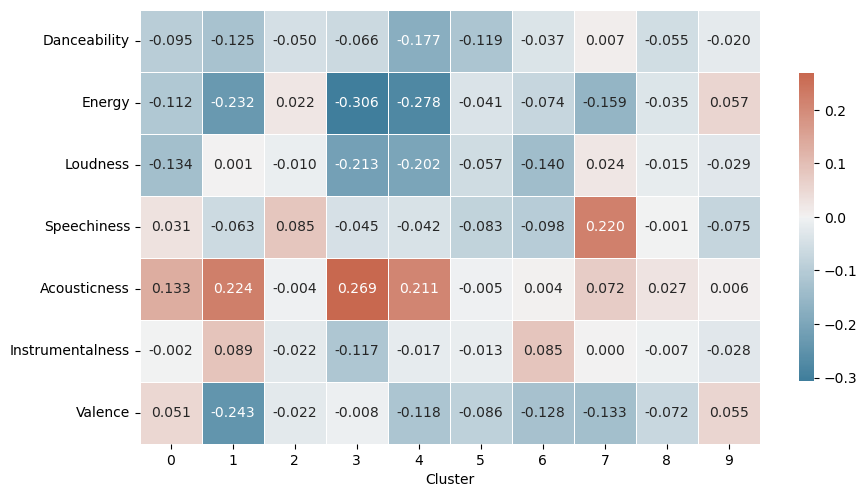

In [151]:
df_raw = df_result.drop(columns=['id']).copy()
df_corr_clus = pd.DataFrame()

for clus in sorted(df_raw["cluster"].unique()):
    df_corr = df_raw[df_raw["cluster"] == clus].drop(columns="cluster").corr()
    df_corr_clus[clus] = df_corr[["count"]].T.drop(columns="count").iloc[0]

# Draw the heatmap
f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap((df_corr_clus), cmap=cmap, center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.3f')

plt.xlabel("Cluster")

# Using features to summarise popularity profile

In [129]:
from scipy.signal import find_peaks

In [178]:
def duration_of_popularity(row):
    non_zero_weeks = row[row > 0].index
    return non_zero_weeks[-1] - non_zero_weeks[0] + 1

def number_of_peaks(row, prominence_threshold=0.1):
    peaks, _ = find_peaks(row, prominence=prominence_threshold)
    return len(peaks)

def time_between_peaks(row, prominence_threshold=0.1):
    peaks, _ = find_peaks(row, prominence=prominence_threshold)
    
    # Calculate time between consecutive peaks
    time_between = [peaks[i+1] - peaks[i] for i in range(len(peaks)-1)]
    
    # Return the average time between peaks
    return pd.Series(time_between).median() if len(time_between) > 0 else 0

summary_data = {'Duration' : pivot_df_norm.apply(duration_of_popularity, axis=1),
        'Number_of_Peaks' : pivot_df_norm.apply(number_of_peaks, axis=1),
        'Time_Between_Peaks' : pivot_df_norm.apply(time_between_peaks, axis=1),
        'Score_at_Week_2' : df_smoothed[8],
        'Score_at_Week_14' : df_smoothed[92],
        'Score_at_Week_26' : df_smoothed[176]}
summary_df = pd.DataFrame(summary_data)
summary_df

,Duration,Number_of_Peaks,Time_Between_Peaks,Score_at_Week_2,Score_at_Week_14,Score_at_Week_26
id,,,,,,
000xQL6tZNLJzIrtIgxqSl,176,1,0.0,150.428571,54.571429,0.285714
003vvx7Niy0yvhvHt4a68B,876,16,5.0,1.857143,0.000000,0.285714
00Blm7zeNqgYLPtW6zg8cj,211,1,0.0,190.000000,145.000000,114.000000
00EPIEnX1JFjff8sC6bccd,120,1,0.0,49.285714,92.000000,0.000000
00ko9WaS4jOX1kEk3gvHjf,120,2,14.0,122.428571,0.000000,0.000000
...,...,...,...,...,...,...
7yotKA30dwTKNEGomV9ZsI,71,0,0.0,188.428571,0.000000,0.000000
7yq4Qj7cqayVTp3FF9CWbm,1786,13,7.5,0.428571,0.000000,0.000000
7ytR5pFWmSjzHJIeQkgog4,519,1,0.0,187.428571,200.000000,186.428571


In [212]:
df_clean[df_clean['Date'] == '2022-12-25']

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL,Day_in_week,Month
44538,13,A Holly Jolly Christmas,Burl Ives,2022-12-25,0.683,0.375,-13056.00,0.030,0.579,0.000,...,Burl Ives,Nationality 1,United States,Anglo-America,188,188.0,77khP2fIVhSW23NwxrRluh,https://open.spotify.com/track/77khP2fIVhSW23N...,6,12
44540,1,All I Want for Christmas Is You,Mariah Carey,2022-12-25,0.336,0.627,-7463.00,0.038,0.164,0.000,...,Mariah Carey,Nationality 1,United States,Anglo-America,200,200.0,0bYg9bo50gSsH3LtXe2SQn,https://open.spotify.com/track/0bYg9bo50gSsH3L...,6,12
44541,98,Another Love,Tom Odell,2022-12-25,0.442,0.538,-8.55,0.045,0.717,0.000,...,Tom Odell,Nationality 1,United Kingdom,Europe,103,103.0,7jtQIBanIiJOMS6RyCx6jZ,https://open.spotify.com/track/7jtQIBanIiJOMS6...,6,12
44545,51,As It Was,Harry Styles,2022-12-25,0.520,0.731,-5338.00,0.056,0.342,0.001,...,Harry Styles,Nationality 1,United Kingdom,Europe,150,150.0,4Dvkj6JhhA12EX05fT7y2e,https://open.spotify.com/track/4Dvkj6JhhA12EX0...,6,12
44550,63,"Baby, It's Cold Outside",Dean Martin,2022-12-25,0.469,0.196,-16093.00,0.057,0.882,0.000,...,Dean Martin,Nationality 1,United States,Anglo-America,138,138.0,4MrfQL4TYQXJBlZYpAHTuE,https://open.spotify.com/track/4MrfQL4TYQXJBlZ...,6,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44783,73,Tití Me Preguntó,Bad Bunny,2022-12-25,0.650,0.715,-5198.00,0.253,0.099,0.000,...,Bad Bunny,Nationality 1,Puerto Rico,Latin-America,128,128.0,1IHWl5LamUGEuP4ozKQSXZ,https://open.spotify.com/track/1IHWl5LamUGEuP4...,6,12
44792,12,Underneath the Tree,Kelly Clarkson,2022-12-25,0.509,0.812,-5438.00,0.054,0.001,0.000,...,Kelly Clarkson,Nationality 1,United States,Anglo-America,189,189.0,3nAp4IvdMPPWEH9uuXFFV5,https://open.spotify.com/track/3nAp4IvdMPPWEH9...,6,12
44804,22,White Christmas,"Bing Crosby, Ken Darby Singers, John Scott Tro...",2022-12-25,0.317,0.158,-16485.00,0.038,0.673,0.353,...,John Scott Trotter & His Orchestra,Nationality 3,United States,Anglo-America,179,60.0,4so0Wek9Ig1p6CRCHuINwW,https://open.spotify.com/track/4so0Wek9Ig1p6CR...,6,12
44808,18,Wonderful Christmastime - Edited Version / Rem...,Paul McCartney,2022-12-25,0.774,0.511,-8914.00,0.032,0.322,0.000,...,Paul McCartney,Nationality 1,United Kingdom,Europe,183,183.0,1SV1fxF65n9NhRHp3KlBuu,https://open.spotify.com/track/1SV1fxF65n9NhRH...,6,12


id: 0bYg9bo50gSsH3LtXe2SQn | Total count: 349
Song: All I Want for Christmas Is You | Artists: Mariah Carey | Continent: Anglo-America


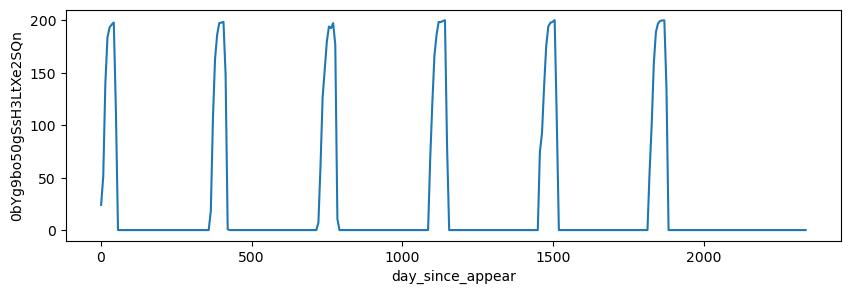

Duration              1877.0
Number_of_Peaks          6.0
Time_Between_Peaks      52.0
Score_at_Week_2         51.0
Score_at_Week_14         0.0
Score_at_Week_26         0.0
Name: 0bYg9bo50gSsH3LtXe2SQn, dtype: float64


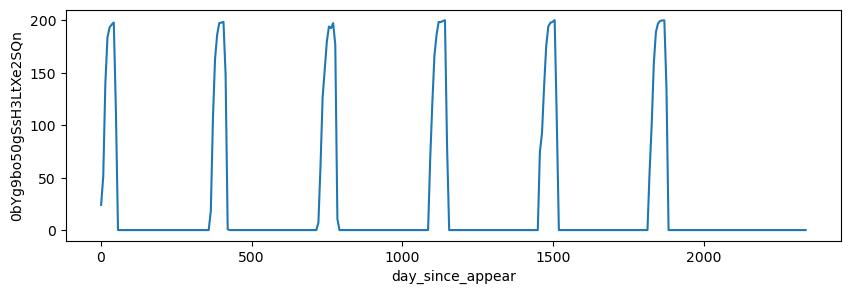

In [224]:
# sample = df_smoothed.sample(n=1)
sample = df_smoothed.loc["0bYg9bo50gSsH3LtXe2SQn"]
df_focus = df_clean[df_clean['id'] == '0bYg9bo50gSsH3LtXe2SQn']

print(f'id: 0bYg9bo50gSsH3LtXe2SQn | Total count: {df_focus.shape[0]}')
print(f'Song: {df_focus["Title"].iloc[0]} | Artists: {df_focus["Artists"].iloc[0]} | Continent: {df_focus["Continent"].iloc[0]}')

# Histogram
# plt.figure(figsize=(10, 3))
# sns.histplot(df_focus["Date"], bins=50)

# Popularity over time
plt.show()
plt.figure(figsize=(10, 3))
sns.lineplot(data=df_smoothed.loc['0bYg9bo50gSsH3LtXe2SQn'])

plt.show()
plt.figure(figsize=(10,3))
sns.lineplot(df_smoothed.loc['0bYg9bo50gSsH3LtXe2SQn'])

print(summary_df.loc['0bYg9bo50gSsH3LtXe2SQn'])

In [155]:
df_smoothed.index[0]

'000xQL6tZNLJzIrtIgxqSl'

In [220]:
sample

Int64Index([   1,    8,   15,   22,   29,   36,   43,   50,   57,   64,
            ...
            2276, 2283, 2290, 2297, 2304, 2311, 2318, 2325, 2332, 2339],
           dtype='int64', name='day_since_appear', length=335)